In [1]:
"""Plot variance explained by (fluxes*ECCO adjoint sensitivities)."""


import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
from os.path import join,expanduser

user_home_dir = expanduser('~')

# grid file
grid_filename = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC','ECCO_L4_GEOMETRY_LLC0090GRID_V4R4',\
                     'GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ds_grid = xr.open_dataset(grid_filename)


# # years included in prediction
years_to_predict = np.arange(1997,2018)



# # forcing case identifier (e.g., 'ERA5', 'ECCO_JRA55do')
case_id = 'ECCO_JRA55do'

# # variance explained of reconstruction ('reconstr') or obs ('tgauge')
varexp_type = 'altim'

# # maximum lead time ID
maxlead_id = '5yr'

place_id = 'EasternGulfCoast'


# # year range identifier
year_range_id = "_".join([str(year) for year in years_to_predict[[0,-1]]])

# # filename with variances explained
varexp_dir = join(user_home_dir,'Downloads','ECCO_v4r4_adjoint','forcing_stats')
# varexp_filename = join(varexp_dir,case_id+'_impact_'+varexp_type+'_'+place_id+'_GulfNAtl_regions_'+year_range_id)
varexp_filename = join(varexp_dir,case_id+'_impact_'+varexp_type+'_'+place_id\
                       +'_withtrend_GulfNAtl_regions_'+maxlead_id+'_'+year_range_id)

ds_varexp = xr.open_zarr(varexp_filename).compute()

In [2]:
ds_varexp

<xarray.Dataset> Size: 168MB
Dimensions:                        (tile: 13, j: 90, i: 90, cell: 123, forc: 4,
                                    pred_month: 12, pred_year: 21,
                                    sens_tval: 266, lead_mo: 60)
Coordinates: (12/16)
    XC                             (tile, j, i) float32 421kB -111.6 ... -111.9
    XC_cell                        (cell) float64 984B 270.5 274.3 ... 311.4
    XG                             (tile, j, i) float32 421kB -115.0 ... -109.0
    XG_cell                        (cell) float64 984B nan nan ... -68.0 -68.0
    YC                             (tile, j, i) float32 421kB -88.24 ... -88.1
    YC_cell                        (cell) float64 984B 28.8 25.74 ... -73.57
    ...                             ...
    forc_time                      (pred_month, sens_tval, pred_year) datetime64[ns] 536kB ...
  * pred_month                     (pred_month) int32 48B 1 2 3 4 ... 9 10 11 12
    pred_time                      (pred_month, pred_year) datetime64[ns] 2kB ...
  * pred_year                      (pred_year) int32 84B 1997 1998 ... 2016 2017
    sens_time                      (pred_month, sens_tval) datetime64[ns] 26kB ...
    sens_time_end                  (pred_month, sens_tval) datetime64[ns] 26kB ...
Dimensions without coordinates: tile, j, i, cell, sens_tval, lead_mo
Data variables: (12/14)
    all_impact_forc_attimes        (forc, pred_month, pred_year) float32 4kB ...
    all_impact_senststep_attimes   (pred_month, sens_tval, pred_year) float32 268kB ...
    cum_frac_varexp_cell           (forc, pred_month, sens_tval, cell) float64 13MB ...
    cum_frac_varexp_cell_allforc   (pred_month, sens_tval, cell) float64 3MB ...
    frac_varexp_cell               (forc, pred_month, sens_tval, cell) float64 13MB ...
    frac_varexp_cell_allforc       (pred_month, sens_tval, cell) float64 3MB ...
    ...                             ...
    obs_tseries_var                (pred_month) float64 96B 0.002487 ... 0.00...
    predict_lead_mo                (pred_month, pred_year, lead_mo) float64 121kB ...
    preinit_cell_impact_attimes    (forc, pred_month, sens_tval, pred_year, cell) float32 132MB ...
    rA_cell                        (cell) float64 984B 1.906e+10 ... 5.422e+11
    reconstr_total                 (pred_month, pred_year) float32 1kB 0.0138...
    reconstr_var                   (pred_month) float64 96B 0.001306 ... 0.00...

In [3]:
if place_id in ['EasternGulfCoast','WesternGulfCoast','GulfCoast']:
    place_is_regionavg = True
else:
    place_is_regionavg = False

if place_is_regionavg:
    mask_unshaped = np.fromfile(join(expanduser('~'),'Downloads','ECCO_v4r4_adjoint',\
                                     'adjoint_sensitivities',place_id,\
                                'mask_'+place_id+'.bin'),dtype='>f4')
    mask_regionavg = np.empty((13,90,90)).astype('float32')
    mask_regionavg[:7,:,:] = np.reshape(mask_unshaped[:(7*90*90)],(7,90,90))
    mask_rot = np.reshape(mask_unshaped[(7*90*90):],(180,270))
    for tile_ind in range(7,10):
        mask_regionavg[tile_ind,:,:] = mask_rot[:90,90*(tile_ind-7):90*(tile_ind-6)]
    for tile_ind in range(10,13):
        mask_regionavg[tile_ind,:,:] = mask_rot[90:,90*(tile_ind-10):90*(tile_ind-9)]

C:\Users\adelman\AppData\Local\Temp\ipykernel_8016\246655494.py:10: RuntimeWarning: overflow encountered in cast
  mask_regionavg = np.empty((13,90,90)).astype('float32')


In [4]:
import ecco_v4_py as ecco


lon_centers_grid,lat_centers_grid,\
lon_edges_grid,lat_edges_grid,\
cell_indexing_latlon_grid = ecco.resample_to_latlon(ds_varexp.XC.values,ds_varexp.YC.values,\
                                                      ds_varexp.cell_indexing.values,\
                                                      new_grid_min_lat=-90,new_grid_max_lat=90,\
                                                      new_grid_delta_lat=.1,\
                                                      new_grid_min_lon=-180,new_grid_max_lon=180,\
                                                      new_grid_delta_lon=.1,\
                                                      mapping_method='nearest_neighbor')

if place_is_regionavg:
    mask_regionavg_latlon_grid = ecco.resample_to_latlon(ds_varexp.XC.values,ds_varexp.YC.values,\
                                                          mask_regionavg,\
                                                          new_grid_min_lat=-90,new_grid_max_lat=90,\
                                                          new_grid_delta_lat=.1,\
                                                          new_grid_min_lon=-180,new_grid_max_lon=180,\
                                                          new_grid_delta_lon=.1,\
                                                          mapping_method='nearest_neighbor')[-1]

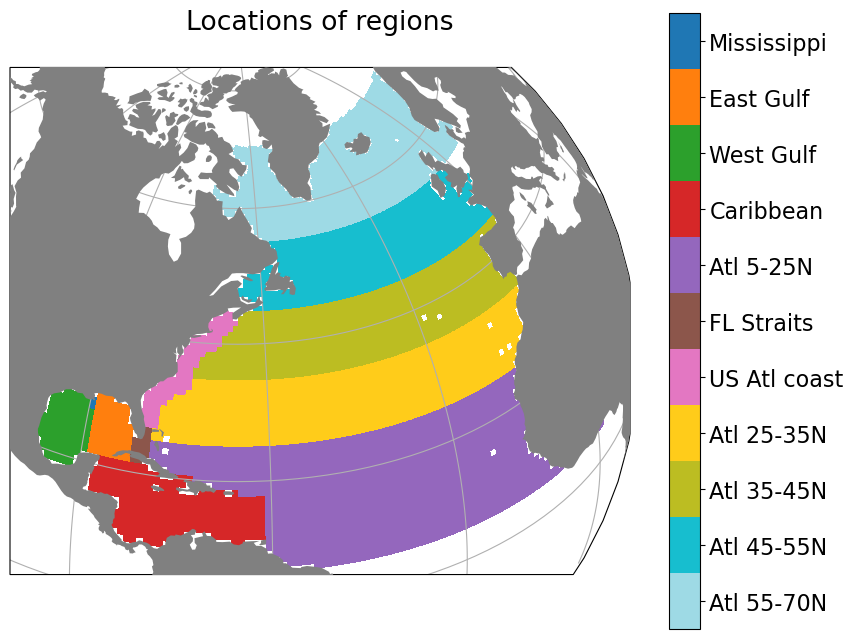

In [11]:
import matplotlib
from matplotlib.colors import ListedColormap

import cartopy
import cartopy.crs as ccrs


region_names = ['Mississippi','East Gulf','West Gulf','Caribbean','Atl 5-25N',\
                'FL Straits','US Atl coast','Atl 25-35N','Atl 35-45N','Atl 45-55N','Atl 55-70N']

n_regions = len(region_names)

cell_indexing_latlon_plot = np.where(np.logical_and(cell_indexing_latlon_grid >= 0,\
                                                    cell_indexing_latlon_grid < 11),\
                                     cell_indexing_latlon_grid.astype('float64'),np.nan)

# curr_cmap = matplotlib.colormaps['Accent'].resampled(7).copy()
# curr_cmap.colors[2,:] = np.array([.95,.65,.4,1])
# curr_cmap.colors[3,:] = np.array([1,.9,.1,1])
curr_cmap = matplotlib.colormaps['tab20'].resampled(11).copy()
curr_cmap.colors[7,:] = np.array([1,.8,.1,1])


curr_cmap = ListedColormap(curr_cmap(range(0,11)))

plt.rcParams['font.size'] = 16
fig,ax = plt.subplots(1,1,figsize=(10,8),\
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-65,central_latitude=38)})
curr_plot = ax.pcolormesh(lon_centers_grid,lat_centers_grid,cell_indexing_latlon_plot,\
                          transform=ccrs.PlateCarree(),cmap=curr_cmap,vmin=-0.5,vmax=10.5)
ax.set_extent([-100,15,5,74],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND,facecolor=(.5,.5,.5),zorder=100)
ax.gridlines()
ax.set_title('Locations of regions\n')
curr_cbar = plt.colorbar(curr_plot)
curr_cbar.set_ticks(ticks=np.arange(0,11),\
                    labels=region_names)
curr_cbar.ax.invert_yaxis()

plt.savefig('GulfNAtl_region_locations_3.png')
plt.show()

In [64]:
# plot contributions from individual regions

if varexp_type == 'reconstr':
    obs_tseries_sortmonth = ds_varexp.reconstr_tseries_sortmonth.values
    obs_tseries_var = ds_varexp.reconstr_tseries_var.values
else:
    obs_tseries_sortmonth = ds_varexp.obs_tseries_sortmonth.values
    obs_tseries_var = ds_varexp.obs_tseries_var.values


ind_sens_basis_year = (ds_varexp.pred_year.values == 2004).nonzero()[0][0]    

n_obs_inmonth = np.sum(~np.isnan(obs_tseries_sortmonth),axis=-1)
n_good_tsteps_inmonth = np.sum(np.abs(ds_varexp.frac_varexp_cell[0,:,:,0].values) >= 1.e-20,axis=1)
sum_resid_var = np.zeros(tuple([ds_varexp.cum_frac_varexp_cell.shape[ndim] for ndim in [0,2,3]]))
sum_weighted_obs_var = np.zeros(tuple([ds_varexp.cum_frac_varexp_cell.shape[ndim] for ndim in [0,2,3]]))
sum_lead_tstep_mask = np.zeros((ds_varexp.sizes['sens_tval'],))
sum_lead_tstep_days = np.zeros((ds_varexp.sizes['sens_tval'],))
for pred_count in range(ds_varexp.sizes['pred_month']):
    curr_resid_var = ((n_obs_inmonth*obs_tseries_var)[pred_count])\
                                       *(1 - ds_varexp.cum_frac_varexp_cell\
                                         .isel(pred_month=pred_count,\
                                               sens_tval=slice(0,n_good_tsteps_inmonth[pred_count],None))\
                                         .values)
    curr_mask = (~np.isnan(curr_resid_var))
    sum_resid_var[:,-n_good_tsteps_inmonth[pred_count]:,:] += ((~np.isnan(curr_resid_var))*curr_resid_var)
    sum_weighted_obs_var[:,-n_good_tsteps_inmonth[pred_count]:,:] += (curr_mask*\
                                                                      (n_obs_inmonth*obs_tseries_var)[pred_count])
    
    sum_lead_tstep_mask[-n_good_tsteps_inmonth[pred_count]:] += 1
    curr_lead_tstep_days = (ds_varexp.pred_time.isel(pred_month=pred_count,pred_year=ind_sens_basis_year)\
                            - ds_varexp.sens_time.isel(pred_month=pred_count,\
                                                       sens_tval=slice(0,n_good_tsteps_inmonth[pred_count],None)))\
                            .values.astype('timedelta64[D]').astype('float64')
    curr_lead_tstep_days[np.abs(curr_lead_tstep_days) > 1.e5] = 0
    sum_lead_tstep_days[-n_good_tsteps_inmonth[pred_count]:] += curr_lead_tstep_days

curr_frac_varexp_array = 1 - (sum_resid_var/sum_weighted_obs_var)
mean_lead_tstep_days = sum_lead_tstep_days/sum_lead_tstep_mask

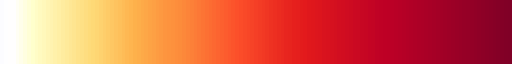

In [25]:
# plot cumulative variance explained as a function of lead time, all seasons

import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap,ListedColormap

array_to_plot = curr_frac_varexp_array[:,1:-1,0:n_regions]
colorscale_min = np.nanmin(array_to_plot)
colorscale_max = 1

neg_pos_ratio = np.abs(colorscale_min)/np.abs(colorscale_max)

curr_cmap = mpl.colormaps['bwr']._resample(262)
cmap_part1 = np.asarray(curr_cmap(range(int(np.round(131-(131*neg_pos_ratio))),132)))
curr_cmap = mpl.colormaps['YlOrRd']._resample(256)
cmap_part2 = np.asarray(curr_cmap(np.concatenate((np.arange(0,60,4),np.arange(60,120,3),np.arange(120,184,2),\
                                          np.arange(184,220,1.5),np.arange(220,256,1)))/256))
cmap_taper_part2 = (np.reshape(np.arange(0.8,0,-0.2),(-1,1))*cmap_part1[[-1],:])\
                        + (np.reshape(np.arange(0.2,1,0.2),(-1,1))*cmap_part2[[0],:])
cmap_taper_part2[cmap_taper_part2 > 1] = 1
full_cmap = ListedColormap(np.vstack((cmap_part1,\
                                      cmap_part1[-1,:],\
                                      cmap_taper_part2,\
                                      cmap_part2)))
full_cmap

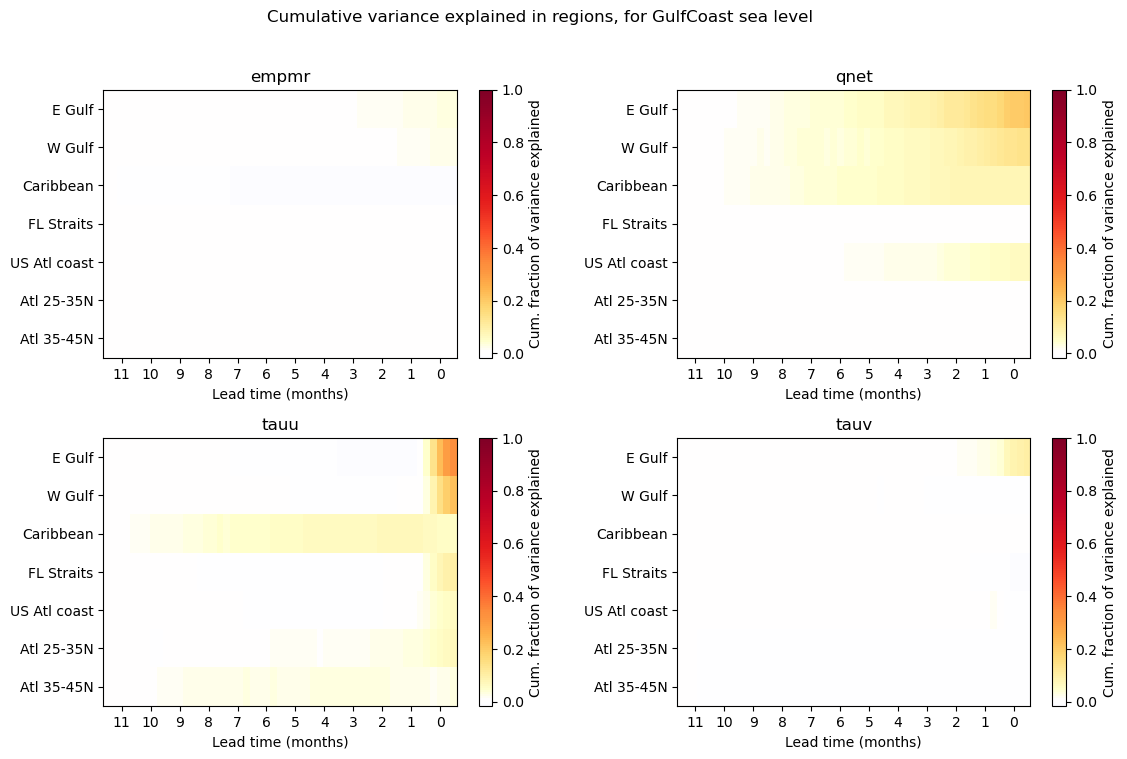

In [26]:
fig,axs = plt.subplots(2,2,figsize=(14,8))
plt.subplots_adjust(right=0.85,wspace=.3,hspace=.3)
for (j_ax,i_ax),n_ax in np.ndenumerate(np.reshape(range(4),(2,2))):
    curr_plot = axs[j_ax,i_ax].pcolormesh(mean_lead_tstep_days[1:-1],np.arange(0,n_regions),\
                                          array_to_plot[n_ax,:,:].transpose(),\
                              cmap=full_cmap,vmin=colorscale_min,vmax=colorscale_max)
    axs[j_ax,i_ax].set_xlim(axs[j_ax,i_ax].get_xlim()[::-1])
    axs[j_ax,i_ax].set_ylim(axs[j_ax,i_ax].get_ylim()[::-1])
    axs[j_ax,i_ax].xaxis.set_ticks(ticks=np.arange((11*(365.24/12)),-15,-(365.24/12)),\
                                     labels=[str(n_mo) for n_mo in range(11,-1,-1)])
    axs[j_ax,i_ax].yaxis.set_ticks(ticks=np.arange(0,n_regions),labels=region_names)
    axs[j_ax,i_ax].set_xlabel('Lead time (months)')
    axs[j_ax,i_ax].set_title(ds_varexp.forc.values[n_ax])
    curr_cbar = plt.colorbar(curr_plot,ax=axs[j_ax,i_ax],label='Cum. fraction of variance explained')

plt.suptitle('Cumulative variance explained in regions, for '+place_id+' sea level       ',x=0.45)
plt.savefig('Varexp_regions_byforc_cum_leadtime_'+case_id+'_'+varexp_type+'_'+place_id+'_'\
                'allmonths_'+year_range_id+'.png')
plt.show()

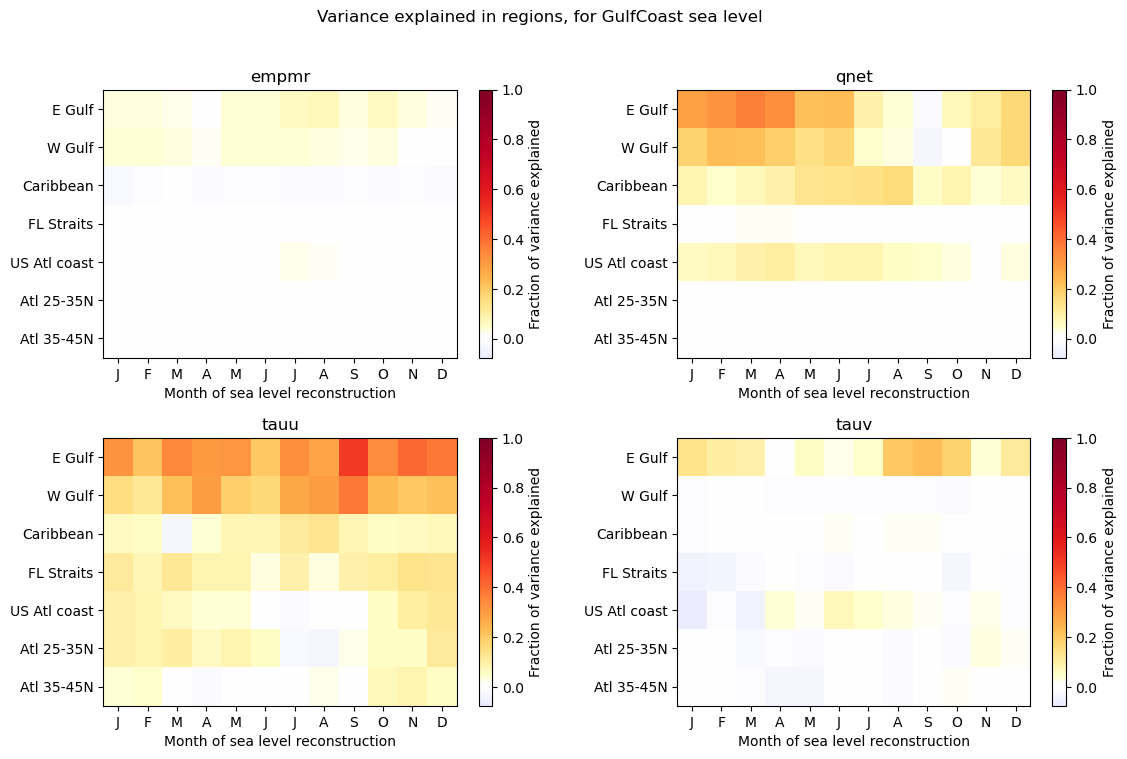

In [27]:
# plot seasonal variation of variance explained

import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap,ListedColormap

array_to_plot = ds_varexp.cum_frac_varexp_cell.isel(sens_tval=-2,cell=np.arange(0,n_regions)).values
array_to_plot[:,[2,5],:] = \
                ds_varexp.cum_frac_varexp_cell.isel(pred_month=[2,5],sens_tval=-1,cell=np.arange(0,n_regions)).values
colorscale_min = np.nanmin(array_to_plot)
colorscale_max = 1

neg_pos_ratio = np.abs(colorscale_min)/np.abs(colorscale_max)

curr_cmap = mpl.colormaps['bwr']._resample(262)
cmap_part1 = np.asarray(curr_cmap(range(int(np.round(131-(131*neg_pos_ratio))),132)))
curr_cmap = mpl.colormaps['YlOrRd']._resample(256)
cmap_part2 = np.asarray(curr_cmap(np.concatenate((np.arange(0,60,4),np.arange(60,120,3),np.arange(120,184,2),\
                                          np.arange(184,220,1.5),np.arange(220,256,1)))/256))
cmap_taper_part2 = (np.reshape(np.arange(0.8,0,-0.2),(-1,1))*cmap_part1[[-1],:])\
                        + (np.reshape(np.arange(0.2,1,0.2),(-1,1))*cmap_part2[[0],:])
cmap_taper_part2[cmap_taper_part2 > 1] = 1
full_cmap = ListedColormap(np.vstack((cmap_part1,\
                                      cmap_part1[-1,:],\
                                      cmap_taper_part2,\
                                      cmap_part2)))


fig,axs = plt.subplots(2,2,figsize=(14,8))
plt.subplots_adjust(right=0.85,wspace=.3,hspace=.3)
for (j_ax,i_ax),n_ax in np.ndenumerate(np.reshape(range(4),(2,2))):
    curr_plot = axs[j_ax,i_ax].pcolormesh(np.arange(1,13),np.arange(0,7),\
                                          array_to_plot[n_ax,:,:].transpose(),\
                              cmap=full_cmap,vmin=colorscale_min,vmax=colorscale_max)
    axs[j_ax,i_ax].set_ylim(axs[j_ax,i_ax].get_ylim()[::-1])
    axs[j_ax,i_ax].xaxis.set_ticks(ticks=np.arange(1,13),\
                                     labels=['J','F','M','A','M','J','J','A','S','O','N','D'])
    axs[j_ax,i_ax].yaxis.set_ticks(ticks=np.arange(0,n_regions),labels=region_names)
    axs[j_ax,i_ax].set_xlabel('Month of sea level reconstruction')
    axs[j_ax,i_ax].set_title(ds_varexp.forc.values[n_ax])
    curr_cbar = plt.colorbar(curr_plot,ax=axs[j_ax,i_ax],label='Fraction of variance explained')

plt.suptitle('Variance explained in regions, for '+place_id+' sea level       ',x=0.45)
plt.savefig('Varexp_regions_byforc_predmonth_'+case_id+'_'+varexp_type+'_'+place_id+'_'\
                +year_range_id+'.png')
plt.show()

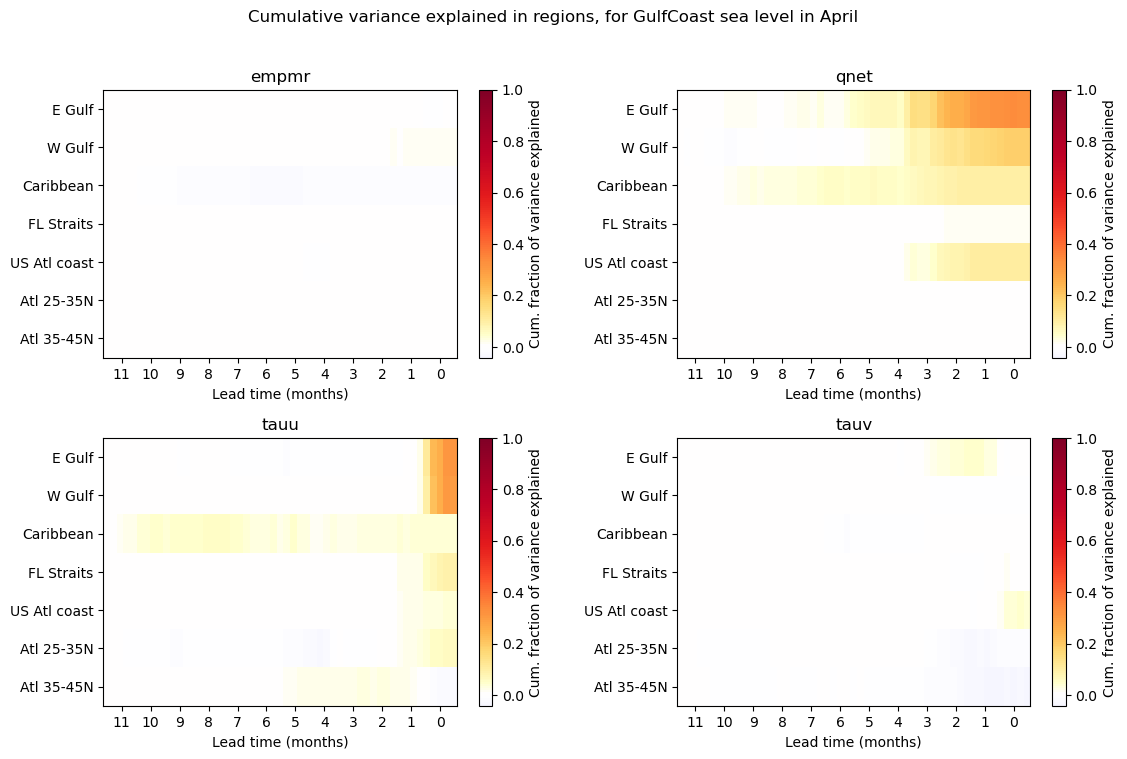

In [65]:
# plot cumulative variance explained for a specific month

import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap,ListedColormap

month_to_plot = 'April'
month_num = 4

array_to_plot = ds_varexp.cum_frac_varexp_cell.values[:,month_num-1,1:-1,0:n_regions]
colorscale_min = np.nanmin(array_to_plot)
colorscale_max = 1

neg_pos_ratio = np.abs(colorscale_min)/np.abs(colorscale_max)

curr_cmap = mpl.colormaps['bwr']._resample(262)
cmap_part1 = np.asarray(curr_cmap(range(int(np.round(131-(131*neg_pos_ratio))),132)))
curr_cmap = mpl.colormaps['YlOrRd']._resample(256)
cmap_part2 = np.asarray(curr_cmap(np.concatenate((np.arange(0,60,4),np.arange(60,120,3),np.arange(120,184,2),\
                                          np.arange(184,220,1.5),np.arange(220,256,1)))/256))
cmap_taper_part2 = (np.reshape(np.arange(0.8,0,-0.2),(-1,1))*cmap_part1[[-1],:])\
                        + (np.reshape(np.arange(0.2,1,0.2),(-1,1))*cmap_part2[[0],:])
cmap_taper_part2[cmap_taper_part2 > 1] = 1
full_cmap = ListedColormap(np.vstack((cmap_part1,\
                                      cmap_part1[-1,:],\
                                      cmap_taper_part2,\
                                      cmap_part2)))

fig,axs = plt.subplots(2,2,figsize=(14,8))
plt.subplots_adjust(right=0.85,wspace=.3,hspace=.3)
for (j_ax,i_ax),n_ax in np.ndenumerate(np.reshape(range(4),(2,2))):
    curr_plot = axs[j_ax,i_ax].pcolormesh(mean_lead_tstep_days[1:-1],np.arange(0,n_regions),\
                                          array_to_plot[n_ax,:,:].transpose(),\
                              cmap=full_cmap,vmin=colorscale_min,vmax=colorscale_max)
    axs[j_ax,i_ax].set_xlim(axs[j_ax,i_ax].get_xlim()[::-1])
    axs[j_ax,i_ax].set_ylim(axs[j_ax,i_ax].get_ylim()[::-1])
    axs[j_ax,i_ax].xaxis.set_ticks(ticks=np.arange((11*(365.24/12)),-15,-(365.24/12)),\
                                     labels=[str(n_mo) for n_mo in range(11,-1,-1)])
    axs[j_ax,i_ax].yaxis.set_ticks(ticks=np.arange(0,n_regions),labels=region_names)
    axs[j_ax,i_ax].set_xlabel('Lead time (months)')
    axs[j_ax,i_ax].set_title(ds_varexp.forc.values[n_ax])
    curr_cbar = plt.colorbar(curr_plot,ax=axs[j_ax,i_ax],label='Cum. fraction of variance explained')

plt.suptitle('Cumulative variance explained in regions, for '+place_id+' sea level in '+month_to_plot+'  ',x=0.45)
plt.savefig('Varexp_regions_byforc_cum_leadtime_'+case_id+'_'+varexp_type+'_'+place_id+'_'\
                +month_to_plot[:3]+'_'+year_range_id+'.png')
plt.show()